In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from glob import glob
from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder

In [2]:
print(os.getcwd()) 

C:\Users\hi\Desktop\DeepLearning


In [3]:
base_dir = os.chdir(os.getcwd() + "/img-fashion")
print(os.getcwd())

C:\Users\hi\Desktop\DeepLearning\img-fashion


In [4]:
data_list = glob('*.jpg')
print('파일 개수 >> ', len(data_list))
print('파일 목록 타입 >> ', type(data_list))

파일 개수 >>  7652
파일 목록 타입 >>  <class 'list'>


In [5]:
token = text_to_word_sequence(data_list[0])
print(token)

['blouse', '1', 'jpg']


In [6]:
label = []
for x in data_list:
    token = text_to_word_sequence(x)
    label.append(token[0])
print(len(label))

7652


In [7]:
items = label
encoder = LabelEncoder()
label = encoder.fit_transform(items)
label

array([0, 0, 0, ..., 7, 7, 7], dtype=int64)

In [8]:
data_height = 150
data_width = 150
channel_n = 3

In [9]:
def make_file(dat_height, data_width, channel_n, data_list_len):
    label = []
    images = np.zeros((data_list_len, dat_height, data_width, channel_n))
    
    for i, image in enumerate(data_list):
        
        token = text_to_word_sequence(image)
        label.append(token[0])
        
        image = cv2.imread(image)
        image = cv2.resize(image, (dat_height, data_width)) / 255
        
        images[i, :, :, :] = image
    label = np.array(label)
    return (label, images)    

In [10]:
label, images = make_file(data_height, data_width, channel_n, len(data_list))

In [11]:
items = label
encoder = LabelEncoder()
label = encoder.fit_transform(items)
label, len(label) 

(array([0, 0, 0, ..., 7, 7, 7], dtype=int64), 7652)

In [12]:
x = images
y = label

X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size= 0.1,
                                                    random_state=30
                                                   )
print(X_train.shape, X_test.shape)

(6886, 150, 150, 3) (766, 150, 150, 3)


In [13]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

In [14]:
# Initialising the CNN
cnn = Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [15]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cp = ModelCheckpoint('fashion_cnn_1.h5')

In [16]:
type(cnn)

keras.engine.sequential.Sequential

In [17]:
cnn_history = cnn.fit( X_train, 
                       y_train,                
                       batch_size=32,
                       epochs=15,
                       validation_data = (X_test, y_test),
                       callbacks = [es, cp],
                       verbose=2
                       )

Epoch 1/15
216/216 - 54s - loss: 1.5022 - accuracy: 0.4776 - val_loss: 1.3737 - val_accuracy: 0.5522 - 54s/epoch - 248ms/step
Epoch 2/15
216/216 - 55s - loss: 1.0671 - accuracy: 0.6417 - val_loss: 1.1711 - val_accuracy: 0.6084 - 55s/epoch - 254ms/step
Epoch 3/15
216/216 - 51s - loss: 0.8223 - accuracy: 0.7194 - val_loss: 1.2112 - val_accuracy: 0.5992 - 51s/epoch - 236ms/step
Epoch 4/15
216/216 - 50s - loss: 0.5670 - accuracy: 0.8082 - val_loss: 1.2439 - val_accuracy: 0.6201 - 50s/epoch - 232ms/step
Epoch 5/15
216/216 - 53s - loss: 0.3825 - accuracy: 0.8745 - val_loss: 1.3644 - val_accuracy: 0.6188 - 53s/epoch - 243ms/step
Epoch 6/15
216/216 - 54s - loss: 0.2837 - accuracy: 0.9010 - val_loss: 1.6375 - val_accuracy: 0.6266 - 54s/epoch - 251ms/step
Epoch 7/15
216/216 - 52s - loss: 0.2152 - accuracy: 0.9290 - val_loss: 1.8881 - val_accuracy: 0.6371 - 52s/epoch - 239ms/step


In [18]:
test_result = cnn.evaluate(X_test, y_test)
test_result

24/24 [==============================] - ETA: 1s - loss: 1.2225 - accuracy: 0.59 - ETA: 1s - loss: 1.2503 - accuracy: 0.56 - ETA: 1s - loss: 1.1585 - accuracy: 0.59 - ETA: 1s - loss: 1.0812 - accuracy: 0.60 - ETA: 1s - loss: 1.0790 - accuracy: 0.61 - ETA: 1s - loss: 1.0777 - accuracy: 0.62 - ETA: 1s - loss: 1.0632 - accuracy: 0.62 - ETA: 1s - loss: 1.0818 - accuracy: 0.62 - ETA: 0s - loss: 1.0823 - accuracy: 0.62 - ETA: 0s - loss: 1.1443 - accuracy: 0.62 - ETA: 0s - loss: 1.1632 - accuracy: 0.61 - ETA: 0s - loss: 1.1639 - accuracy: 0.61 - ETA: 0s - loss: 1.1651 - accuracy: 0.61 - ETA: 0s - loss: 1.1591 - accuracy: 0.62 - ETA: 0s - loss: 1.1950 - accuracy: 0.60 - ETA: 0s - loss: 1.1884 - accuracy: 0.60 - ETA: 0s - loss: 1.1934 - accuracy: 0.60 - ETA: 0s - loss: 1.2070 - accuracy: 0.60 - ETA: 0s - loss: 1.1819 - accuracy: 0.61 - ETA: 0s - loss: 1.1819 - accuracy: 0.60 - ETA: 0s - loss: 1.1587 - accuracy: 0.61 - ETA: 0s - loss: 1.1559 - accuracy: 0.61 - ETA: 0s - loss: 1.1663 - accuracy: 

[1.1711231470108032, 0.6083551049232483]

In [23]:
print('test acc: ', round(test_result[1]*100, 2))

test acc:  60.84


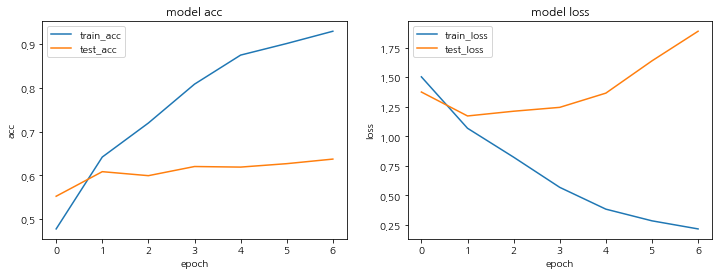

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1) ## 1행2열의 도표, 1열
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc','test_acc'])

plt.subplot(1, 2, 2) ## 1행2열의 도표, 2열
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','test_loss'])